# Lab1 and Lab2: Data Transformation and Feature Engineering 
---

## Introduction

There are two datasets that make up the inputs to our models. The first is insurance claim data and the other is customer data. This data has been *synthetically generated*.

Raw dataset visualization and manipulation will be done using the following libraries: [seaborn](https://seaborn.pydata.org/) and [pandas](https://pandas.pydata.org/). 

We will then generate features and store them using Amazon SageMaker Feature Store. 


This diagram summarizes the next steps

![data-processing.png](images/notebooks/data-processing.png)

1. Data is transformed through Amazon SageMaker Data Wrangler
2. Transformed data is explored and visualized. 
3. Feature engineering on the processed data
3. Prepared data is exported to S3
4. Import S3 data into Amazon SageMaker Feature Store
5. Query Amazon SageMaker Feature Store to generate train/test datasets
6. Optionally run Amazon SageMaker Clarify to detect bias in the dataset

## Index

---

1. [Prerequisites](<#Prerequisites>)
1. [Lab 1: Ingest, Transform And Preprocess Data](<#Lab-1:-Ingest,-Transform-And-Preprocess-Data>)
    1. [Data exploration](<#Data-exploration>)
    1. [Data visualization](<#Data-visualization>)
    1. [Prepare data for training and inference](<#Prepare-data-for-training-and-inference>)
1. [Lab 2: Feature Engineering](<#Lab-2:-Feature-Engineering>)
    1. [Create the Feature Store](#Create-the-Feature-Store)
    1. [Explore Feature Store inside SageMaker Studio](<#Explore-Feature-Store-inside-SageMaker-Studio>)
    1. [Create Train and Test Datasets](<#Create-Train-and-Test-Datasets>)
    1. [Write training and test data to S3](<#Write-training-and-test-data-to-S3>)

## Prerequisites
---

### Install required third-party libraries. 

The default SageMaker notebook container already has many helpful packages like Pandas, Numpy and Matplotlib. But charts generated through Seaborn are visually appealing and easier to read. 

The following python modules will be installed in the next cell:
1. `seaborn`: for data visualization
2. `sagemaker`: Python SDK to call the SageMaker API
3. `boto3`: Python SDK to call the AWS API
4. `pandas`: Python data manipulation library

(if you encounter a warning about pip running as root user - don't worry about it. We're running everything in a container, so it's not going to break anything. You may also incur some incompatible library errors. Re-run cell 1 again to re-install the libraries and to get rid of them) 

In [1]:
# cell 1
# Update pip  and install seaborn for visualization
# !python -m pip install -Uq pip
# !pip install -q seaborn==0.11.1 sagemaker==2.117.0 boto3==1.24.62

## Lab 1: Ingest, Transform And Preprocess Data
---

## Data exploration
---

### Start by importing the data into the notebook.

The data you're going to consume today is available in the `data` folder. As we walk through the workshop you'll find that we create another copy of the data for training purposes. We'll put the training data in an S3 bucket. 

So let's get started by pulling the data into the notebook.

#### Note

<font color="orange">As mentioned in the workshop, in the interest of time, we're going to use the preprocessed data for visualization and feature engineering. This data has been created after the transformations have run on the raw dataset.</font>

<font color="cyan">The transforms have been created using Amazon SageMaker Data Wrangler. If you wish to learn how to create your own transforms check out the Bonus Labs section of the workshop. The Data Wrangler section also teaches you how to create the final transformed datasets `claims_preprocessed.csv` and `customers_preprocessed.csv`</font>

In [1]:
# cell 2
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns  # visualisation
import matplotlib.pyplot as plt  # visualisation

%matplotlib inline

# grab the pastel color set from seaborn
colors = sns.color_palette('pastel')
sns.set(color_codes=True)

# these two variables have the path to the csv files
CLAIMS_DATA_CSV = "./data/claims_preprocessed.csv"
CUSTOMER_DATA_CSV = "./data/customers_preprocessed.csv"


# pull the data into the notebook by reading it from the folder. Let's create two DataFrames
df_claims = pd.read_csv(CLAIMS_DATA_CSV, index_col=0)
df_customers = pd.read_csv(CUSTOMER_DATA_CSV, index_col=0)

### Explore your dataset
If you have a huge dataset, it's generally not possible to import data directly into the notebook. But you can always slice it and load it. Once loaded you can preview it using the `head()` function on the Pandas DataFrame to understand what the column definitions look like

In [2]:
# cell 3

# let's check the claims dataset
df_claims.head()

,incident_severity,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,total_claim_amount,incident_month,incident_day,...,incident_type_breakin,incident_type_theft,collision_type_front,collision_type_rear,collision_type_side,collision_type_na,authorities_contacted_police,authorities_contacted_none,authorities_contacted_fire,authorities_contacted_ambulance
policy_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,3,0,2,1.0,0,15000,15000,11,18,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,2,3,0,0.0,30000,19500,49500,2,26,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,2,0,1,0.0,0,10000,10000,3,18,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1,0,0,0.0,0,14000,14000,1,22,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,0.0,2,0,2,0.0,0,12000,12000,3,30,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
# cell 5

# and the customer dataset
df_customers.head()

,customer_age,customer_education,months_as_customer,policy_deductable,policy_annual_premium,policy_liability,auto_year,num_claims_past_year,num_insurers_past_5_years,customer_gender_male,customer_gender_female,policy_state_ca,policy_state_wa,policy_state_az,policy_state_or,policy_state_nv,policy_state_id
policy_id,,,,,,,,,,,,,,,,,
1,54,2,381,750,3000,1,2019,0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,41,3,31,750,3000,3,2017,0,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,57,3,84,750,3000,3,2014,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,74,4,123,750,2600,2,2018,0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,39,1,34,750,3000,2,2019,0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Check for any missing data

As a data-engineer/scientist before you embark on your adventure, you want to see what the data looks like. Let's check for data inconsistencies.

In [4]:
# cell 6

# This will print if there are any empty rows in the two datasets
print(f"There are {df_claims.isnull().sum().sum()} empty rows in claims.csv")
print(f"There are {df_customers.isnull().sum().sum()} empty rows in customer.csv")

There are 0 empty rows in claims.csv
There are 0 empty rows in customer.csv


### Combine datasets

We should also combine the datasets to understand the correlation between the data

We can use Pandas for this purpose. A combined dataset csv is provided to us in the data folder. Let's read that in. It is also possible to combine to dataframes using Pandas. But we're going to just read in the pre-combined dataset for now.

In [5]:
# cell 7

# You can also combine the datasets directly using two data frames
# df_combined = pd.concat([df_claims, df_customers], axis=1)

# read in the combined csv.
df_combined = pd.read_csv("./data/claims_customer.csv")

# get rid of an unwanted column
df_combined = df_combined.loc[:, ~df_combined.columns.str.contains("^Unnamed: 0")]

# once again, let's check a small slice of the data to check the columns
df_combined.head()

,policy_id,incident_type_theft,policy_state_ca,policy_deductable,num_witnesses,policy_state_or,incident_month,customer_gender_female,num_insurers_past_5_years,customer_gender_male,...,policy_state_id,incident_hour,vehicle_claim,fraud,incident_type_collision,policy_annual_premium,policy_state_az,policy_state_wa,collision_type_rear,collision_type_front
0,1675,0,0,750,0,0,2,0,1,0,...,0,20,12000.0,0,0,3000,1,0,0,0
1,9,0,0,750,0,0,9,0,1,1,...,0,15,18500.0,0,1,3000,0,0,0,0
2,1687,0,1,750,0,0,7,1,1,0,...,0,16,17500.0,0,1,3000,0,0,0,0
3,1687,0,1,750,0,0,7,0,1,1,...,0,16,17500.0,0,1,3000,0,0,0,0
4,1692,0,0,750,2,0,6,1,1,0,...,0,8,21500.0,0,1,2800,1,0,0,1


We can use the `describe` command to generate some statistics about the dataset. This is a very useful comamnd to see distribution of data. You can also use `describe` on a single column of the Dataframe.

In [6]:
# cell 8

df_combined.describe()

,policy_id,incident_type_theft,policy_state_ca,policy_deductable,num_witnesses,policy_state_or,incident_month,customer_gender_female,num_insurers_past_5_years,customer_gender_male,...,policy_state_id,incident_hour,vehicle_claim,fraud,incident_type_collision,policy_annual_premium,policy_state_az,policy_state_wa,collision_type_rear,collision_type_front
count,20000.00000,20000.000000,20000.0000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,2500.50000,0.048200,0.6204,751.13000,0.866100,0.070000,6.713200,0.372400,1.412200,0.576500,...,0.02730,11.786800,17426.083700,0.030000,0.857200,2925.400000,0.113600,0.121000,0.220900,0.425400
std,1443.41173,0.214194,0.4853,13.57322,1.097921,0.255153,3.654396,0.483456,0.897291,0.494125,...,0.16296,5.337918,10043.773599,0.170591,0.349878,143.516096,0.317333,0.326135,0.414864,0.494416
min,1.00000,0.000000,0.0000,750.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.00000,0.000000,1000.000000,0.000000,0.000000,2150.000000,0.000000,0.000000,0.000000,0.000000
25%,1250.75000,0.000000,0.0000,750.00000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,...,0.00000,8.000000,10474.250000,0.000000,1.000000,2900.000000,0.000000,0.000000,0.000000,0.000000
50%,2500.50000,0.000000,1.0000,750.00000,0.000000,0.000000,7.000000,0.000000,1.000000,1.000000,...,0.00000,12.000000,15000.000000,0.000000,1.000000,3000.000000,0.000000,0.000000,0.000000,0.000000
75%,3750.25000,0.000000,1.0000,750.00000,2.000000,0.000000,10.000000,1.000000,1.000000,1.000000,...,0.00000,16.000000,22005.500000,0.000000,1.000000,3000.000000,0.000000,0.000000,0.000000,1.000000
max,5000.00000,1.000000,1.0000,1100.00000,5.000000,1.000000,12.000000,1.000000,5.000000,1.000000,...,1.00000,23.000000,51051.000000,1.000000,1.000000,3000.000000,1.000000,1.000000,1.000000,1.000000


With this combined data lets get some more information like

* `.nunique()` gives us the unique values in a series e.g. `[1, 3, 5, 5, 7]` has 4 unique values
* `.isnull()` gives us a boolean result of whether a value at hand is null or not. We would count the number of unique values and then divide it by the total number of values to get percentage of missing elements
* `.value_counts` gives us the frequency of the occuring value. e.g. `[1, 2, 4, 5, 5, 2]` would give us `{1: 1, 2: 2, 4: 1, 5: 2}`. But if you normalize this, it will represent the relative capacity of the value's occurence. Basically how many times the value has occurred divided by the total values. This is a good way to see the variability in the values of this column.
* `dytpe` give us the data type of the series. e.g. `int`, `float` etc.


In [7]:
# cell 9

combined_stats = []

# loop over all the columns
for col in df_combined.columns:
    
    # append all stats per column to a list
    combined_stats.append(
        (
            col,
            df_combined[col].nunique(),
            df_combined[col].isnull().sum() * 100 / df_combined.shape[0],
            df_combined[col].value_counts(normalize=True, dropna=False).values[0] * 100,
            df_combined[col].dtype,
        )
    )

# finally create a new dataframe with all these values
stats_df = pd.DataFrame(
    combined_stats,
    columns=["feature", "unique_values", "percent_missing", "percent_largest_category", "datatype"],
)

# sort these values by largest category column (descending)
stats_df.sort_values("percent_largest_category", ascending=False)

,feature,unique_values,percent_missing,percent_largest_category,datatype
3,policy_deductable,8,0.0,98.94,int64
28,authorities_contacted_ambulance,2,0.0,97.45,int64
37,policy_state_id,2,0.0,97.27,int64
35,authorities_contacted_fire,2,0.0,97.20,int64
40,fraud,2,0.0,97.00,int64
36,driver_relationship_other,2,0.0,96.06,int64
16,driver_relationship_child,2,0.0,95.49,int64
27,policy_state_nv,2,0.0,95.23,int64
1,incident_type_theft,2,0.0,95.18,int64
23,num_claims_past_year,8,0.0,93.28,int64


## Data visualization

---

Next - let's understand the various columns (which will eventually become features) in the dataset

### Bar plots and Pair plots

Let's take a look at the data distribution of the customer dataset. We notice there are two columns, `gender_male` and `gender_female`. Let's see what the distribution is male to females in this dataset

Text(0.5, 1.0, 'Distribution of male v/s female customers in the dataset')

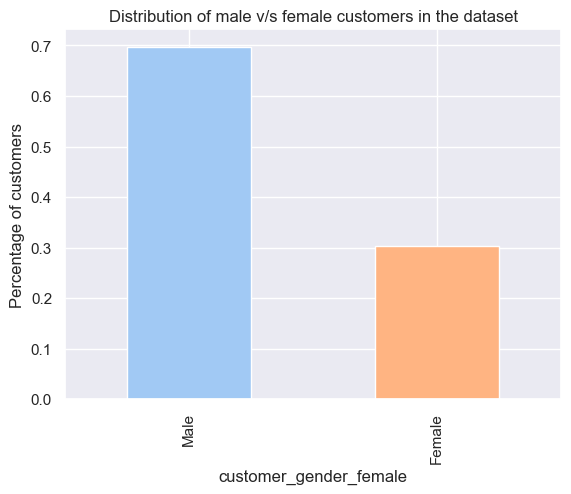

In [8]:
# cell 10

# remember value_count gives us the counts of unique values in a column
df_customers.customer_gender_female.value_counts(normalize=True).plot.bar(color=colors[:2])
plt.xticks([0, 1], ["Male", "Female"]);
plt.ylabel("Percentage of customers")
plt.title("Distribution of male v/s female customers in the dataset")

The distribution is skewed more towards male customers

Next - plot the bar graph of fraudulent claims from the claims dataset

Text(0.5, 1.0, 'Distribution of fraudulent v/s non fraudulent claims')

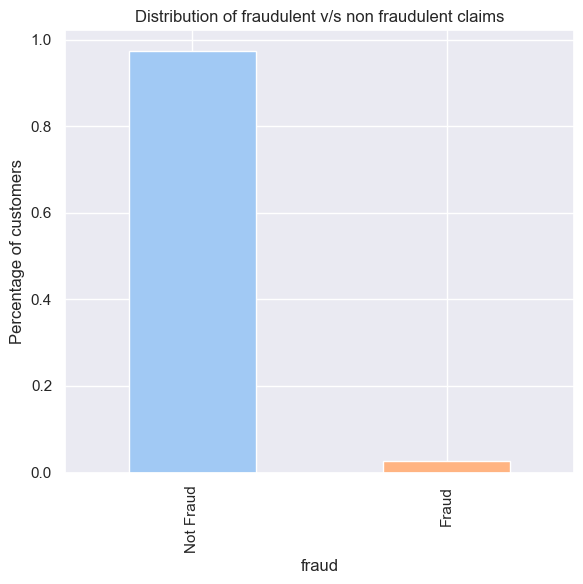

In [9]:
# cell 11

plt.figure(figsize=(6,6), tight_layout=True)
df_claims.fraud.value_counts(normalize=True).plot.bar(color=colors[:2])
plt.xticks([0, 1], ["Not Fraud", "Fraud"]);
plt.ylabel("Percentage of customers")
plt.title("Distribution of fraudulent v/s non fraudulent claims")

Majority of the claims aren't fraudulent which is a good sign

Let's plot the education categories of the customers

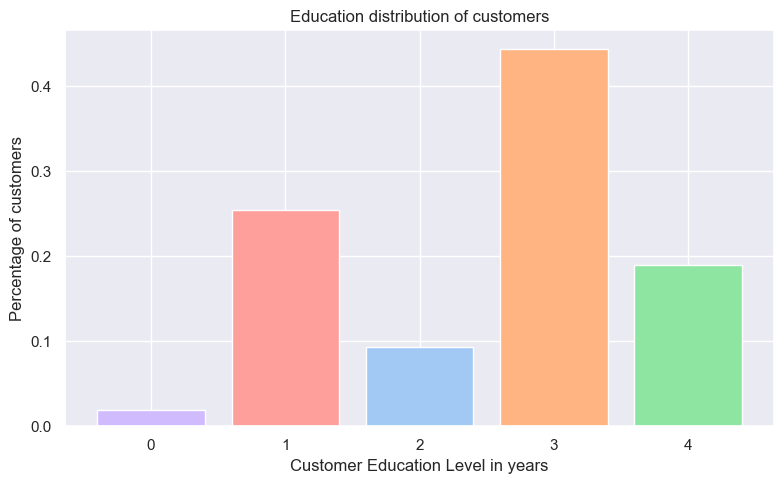

In [10]:
# cell 12

# set size of the plot
plt.figure(figsize=(8,5), tight_layout=True)

# this prepares the data that needs to be displayed
educ = df_customers.customer_education.value_counts(normalize=True, sort=False)

# this plots the bar chart
plt.bar(educ.index, educ.values, color=colors[:5])
plt.title("Education distribution of customers")
plt.ylabel("Percentage of customers")
plt.xlabel("Customer Education Level in years");

Majority of the customers have at least three years of education

Let's plot the total claim amounts

Text(0.5, 1.0, 'Histogram of claim amounts')

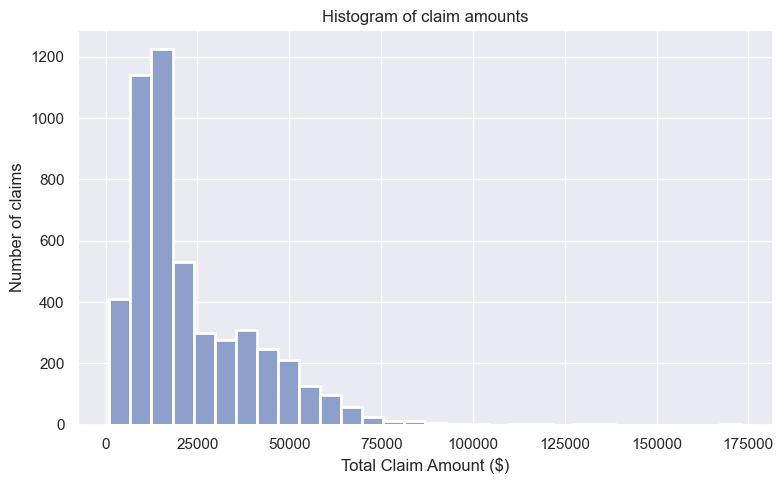

In [11]:
# cell 13

plt.figure(figsize=(8,5), tight_layout=True)

# this will create a histogram with same sized 30 bins
plt.hist(df_claims.total_claim_amount, bins=30, color=sns.color_palette('Set2')[2], linewidth=2)

plt.xlabel("Total Claim Amount ($)")
plt.ylabel("Number of claims")
plt.title("Histogram of claim amounts")

Majority of the total claim amounts are under "$25,000". The higher claim amounts on the x-axis show up in this chart but they have very few numbers of claims against them. Hence, nothing is visible against them on the y-axis.

In [12]:
# cell 13-2 (optional)
# You can verify that there are claims with amounts > $75000 by uncommenting the following lines

# plt.figure(figsize=(10,6), tight_layout=True)
# plt.hist(df_claims.total_claim_amount[lambda x: x >= 100000], color=sns.color_palette('Set2')[2], linewidth=2)
# plt.xlabel("Total Claim Amount ($)")
# plt.ylabel("Number of claims")
# plt.title("Histogram of claim amounts")


Next - plot the number of claims filed in the past year

Text(0, 0.5, 'Number of customers')

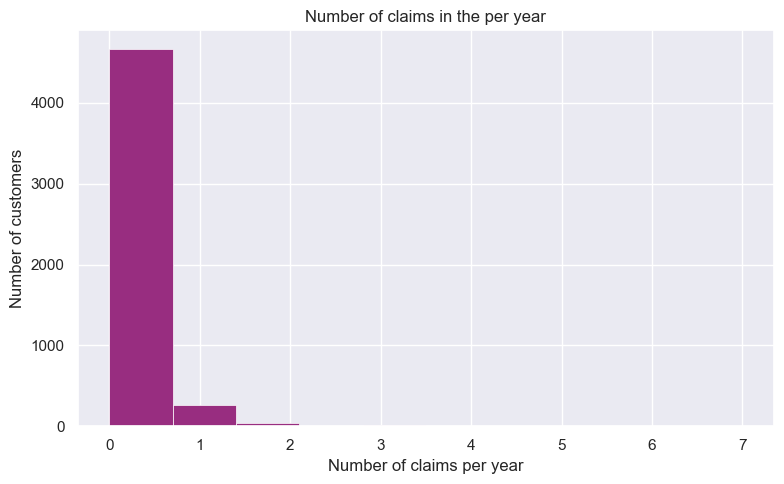

In [13]:
# cell 14

plt.figure(figsize=(8,5), tight_layout=True)
df_customers.num_claims_past_year.hist(color=sns.color_palette('magma')[2], linewidth=0.5)
plt.title("Number of claims in the per year")
plt.xlabel("Number of claims per year")
plt.ylabel("Number of customers")

Most customers did not file any claims in the previous year, but some filed as many as 7 claims. Even though the chart doesn't show a Y value against claims 3 - 7, the fact that these value show up on the x-axis means there are some customers who did file 2 to 7 claims. 

To verify this we can filter out claim numbers 0 to 1 and plot only 2 - 7.

Text(0, 0.5, 'Number of customers')

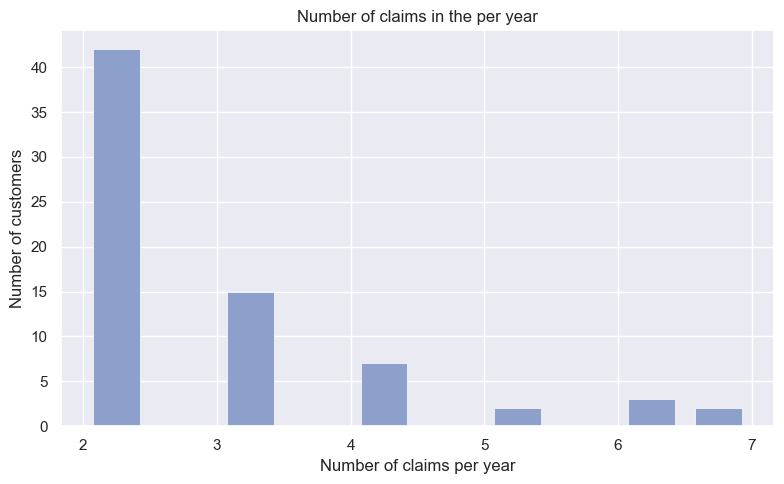

In [14]:
# cell 14-2

plt.figure(figsize=(8,5), tight_layout=True)

# lambda is a python construct which helps in writing functions inline. In this case we keep values >= 2
# This Lambda is not to be confused by AWS Lambda
df_customers.num_claims_past_year[lambda x: x >= 2].hist(color=sns.color_palette('Set2')[2], linewidth=0.5,rwidth=0.7)
plt.title("Number of claims in the per year")
plt.xlabel("Number of claims per year")
plt.ylabel("Number of customers")

As mentioned, a very few number of people filed 2 to 7 claims compared to 4500+ who never a filed a claim

Next, let's check how the fraud claims are distributed between the two genders. 

Text(0, 0.5, 'Total number of fraud cases')

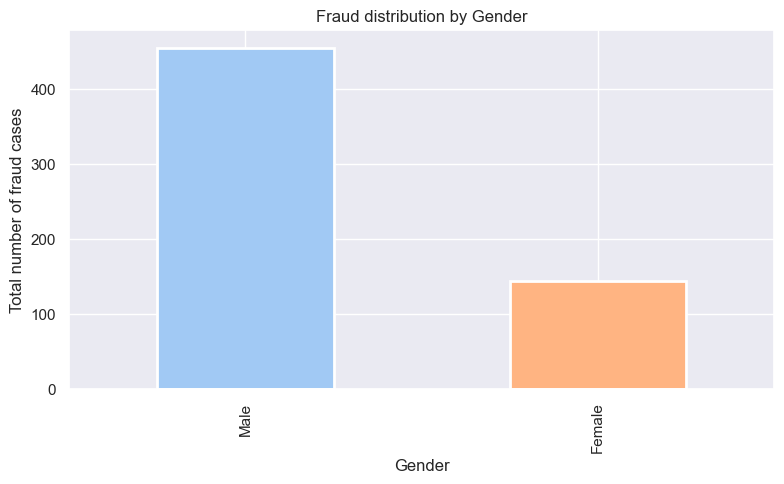

In [15]:
# cell 15

plt.figure(figsize=(8,5), tight_layout=True)
df_combined.groupby("customer_gender_female").sum()["fraud"].plot.bar(color=colors[:2], linewidth=2)
plt.xticks([0, 1], ["Male", "Female"])
plt.title("Fraud distribution by Gender");
plt.xlabel("Gender")
plt.ylabel("Total number of fraud cases")

Fraudulent claims seem to come disproportionately from male customers.

/Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` 

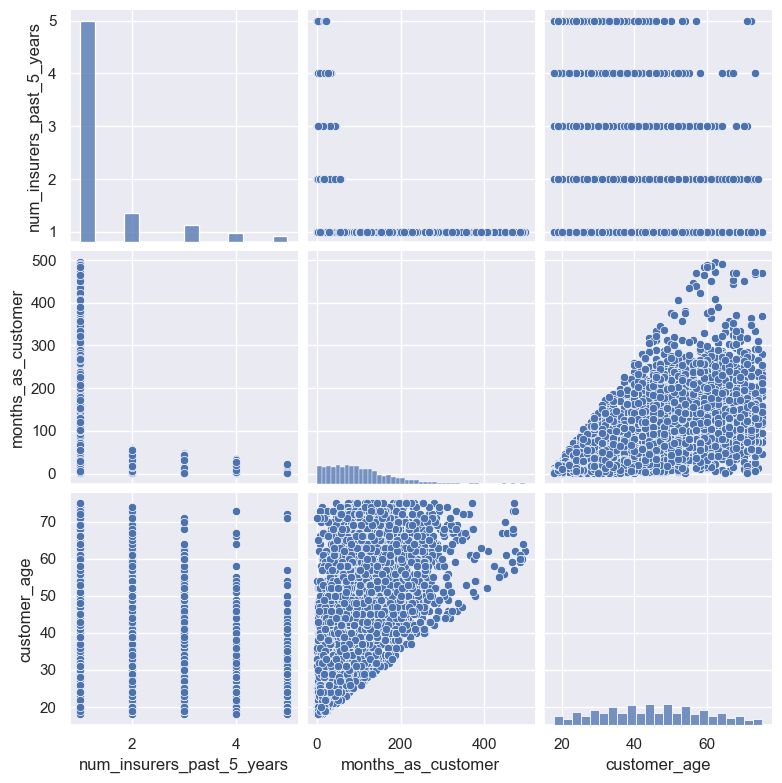

In [16]:
# cell 16

ax = sns.pairplot(
    data=df_customers, 
    vars=["num_insurers_past_5_years", "months_as_customer", "customer_age"],
    palette='Set2'
);
ax.fig.set_figheight(8)
ax.fig.set_figwidth(8)

Understandably, the `months_as_customer` and `customer_age` are correlated with each other. A younger person has been driving for a shorter time and therefore they have a shorter duration as a customer.

We can also see that the `num_insurers_past_5_years` is negatively correlated with `months_as_customer`. If someone frequently jumped around to different insurers, then they probably spent less time as a customer for this insurer.

/var/folders/q9/bmm0955s04zby06p4x69zt140000gn/T/ipykernel_86818/2772346492.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x="num_insurers_past_5_years", y="fraud", data=df_combined, palette="Set2");


[Text(0.5, 1.0, 'Correlation between number of insurers and fraud cases'),
 Text(0.5, 0, 'Number of insurers in the past 5 years'),
 Text(0, 0.5, 'Number of fraud cases')]

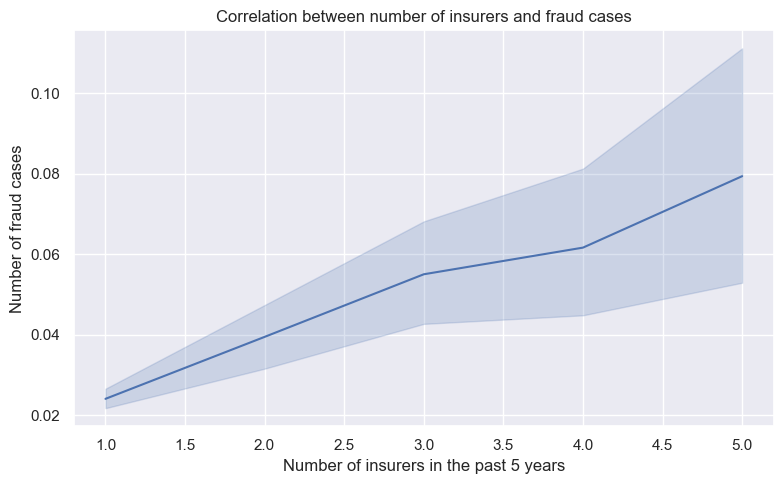

In [17]:
# cell 17

plt.figure(figsize=(8,5), tight_layout=True)
ax = sns.lineplot(x="num_insurers_past_5_years", y="fraud", data=df_combined, palette="Set2");
ax.set(title="Correlation between number of insurers and fraud cases", xlabel="Number of insurers in the past 5 years", ylabel="Number of fraud cases")

<font color="cyan">Fraud is positively correlated with having a greater number of insurers over the past 5 years. Customers who switched insurers more frequently also had more prevelance of fraud</font>

Now let's understand the age distribution in our dataset. We're going to rely on a density and a histogram plot

[Text(0.5, 1.0, 'Distribution of customer age'), Text(0.5, 0, 'Customer age')]

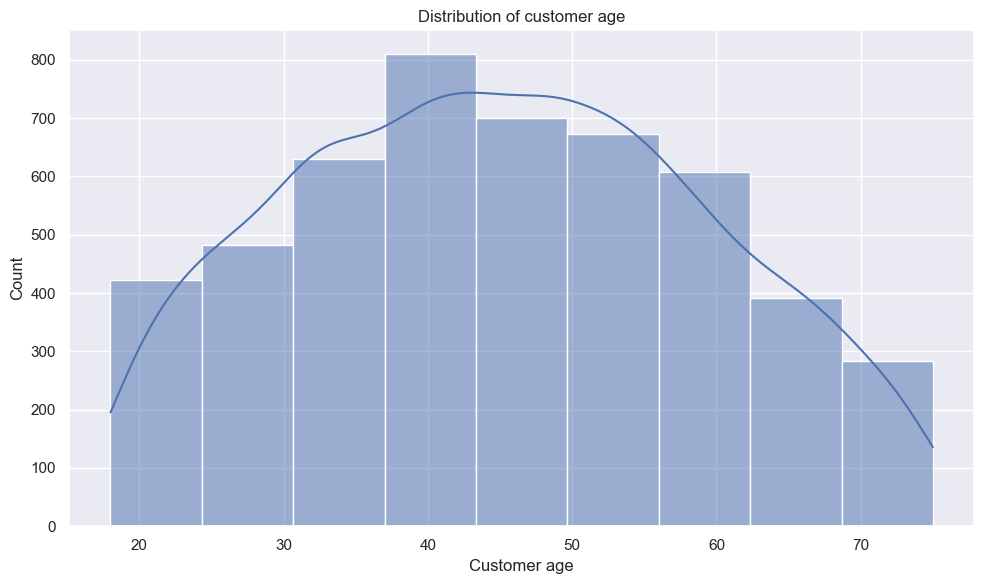

In [18]:
# cell 18

plt.figure(figsize=(10,6), tight_layout=True)
ax = sns.histplot(df_customers, x="customer_age", fill=True, bins=9, kde=True)
ax.set(title="Distribution of customer age", xlabel="Customer age")

The age distribution is somewhat symmetric. We see a higher density of customers between the ages of 35 to 50. This can be further confirmed by the `describe` call on the df_customers dataframe `customer_age` column.

In [19]:
# cell 18-2

df_customers.customer_age.describe()

count    5000.000000
mean       45.085400
std        14.290254
min        18.000000
25%        34.000000
50%        45.000000
75%        56.000000
max        75.000000
Name: customer_age, dtype: float64

<font color='cyan'>75% of the users are less than or equal to 56 years old</font>

### Box plots

*A brief explanation:*
Box plots divide the data into sections that each contain approximately 25% of the data in that set. These sections are called Quartiles. It is a way to see dispersion (variability, scatter or spread) of the data along with outliers. Outliers are data points that are numerically far away from rest of the data and are usually not considered for training.

The smallest value and largest value are found at the end of the ‘whiskers’ and are useful for providing a visual indicator regarding the spread of scores (e.g. the range).

The line at the center of the box plot is the median. 



/var/folders/q9/bmm0955s04zby06p4x69zt140000gn/T/ipykernel_86818/1399423072.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=df_customers["months_as_customer"], palette='Set2', linewidth=2.5);


[Text(0.5, 1.0, 'Distribution of months as customers'),
 Text(0.5, 0, 'Distribution of customers')]

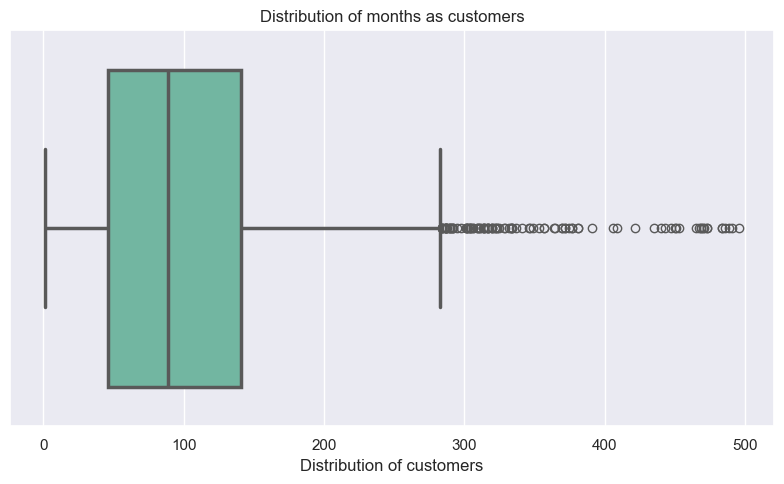

In [20]:
# cell 19

plt.figure(figsize=(8,5), tight_layout=True)
ax = sns.boxplot(x=df_customers["months_as_customer"], palette='Set2', linewidth=2.5);
ax.set(title='Distribution of months as customers', xlabel='Distribution of customers')

In this box plot we can see there are datapoints outside of the distribution. <font color="orange">These are outliers</font>. The median in this plot shows that the median "months as customer" is less than 100 (~8.3y). 


The majority of the customers have been customers from 50 to 150 months. Again, this can be confirmed if we use the `describe` call on the `df_customers` dataframe

In [21]:
# cell 19-2

df_customers.months_as_customer.describe()

count    5000.000000
mean      101.328200
std        73.718143
min         1.000000
25%        46.000000
50%        89.000000
75%       141.000000
max       496.000000
Name: months_as_customer, dtype: float64

### Correlation matrices

[Text(0, 0.5, 'fraud'),
 Text(0, 1.5, 'customer_gender_male'),
 Text(0, 2.5, 'customer_gender_female'),
 Text(0, 3.5, 'months_as_customer'),
 Text(0, 4.5, 'num_insurers_past_5_years')]

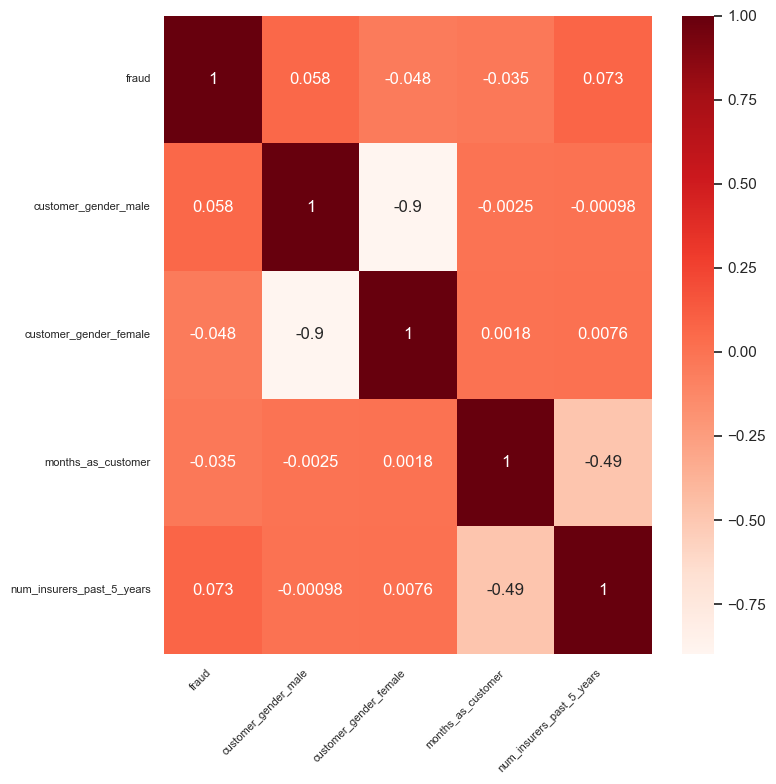

In [22]:
# cell 20

# Creating a correlation matrix of fraud, gender, months as customer, and number of different insurers

plt.figure(figsize=(8,8), tight_layout=True)
cols = [
    "fraud",
    "customer_gender_male",
    "customer_gender_female",
    "months_as_customer",
    "num_insurers_past_5_years",
]
corr = df_combined[cols].corr()

# plot the correlation matrix
ax = sns.heatmap(corr, annot=True, cmap="Reds");

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=8, ha="right", rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=8, va="center", rotation=0)


Fraud is correlated with having more insurers in the past 5 years, and negatively correlated with being a customer for a longer period of time. These go hand in hand and means that long time customers are less likely to commit fraud.

Other statistical insights:
* Negative correlation between `fraud` and female customers and positive correlation between `fraud` and the male gender. This insight was confirmed in our previous section with barcharts. 
* Looking at these correlations some may look obvious but correlation charts give a good idea of magnitude of the relationship. What that means is it's one thing to instinctively know that if a certain metric increases the other positively correlated metric will increase as well. However, the rate at which it grows also plays an important part in the analysis.

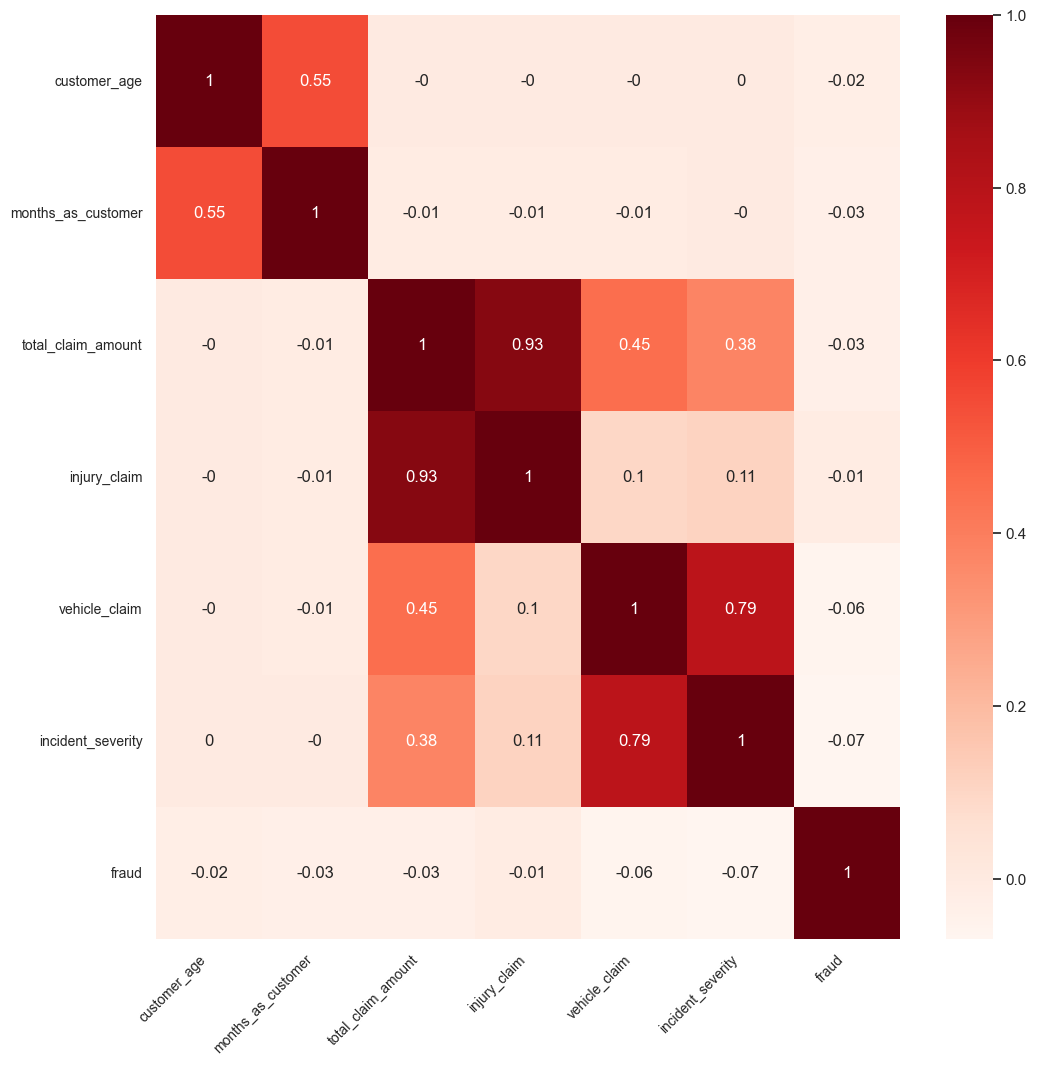

In [23]:
# cell 21

import matplotlib.pyplot as plt
import numpy as np

# set the background to white so the chart is readable
sns.set_style("white")

# we're going to stack the following columns against each other for correlations
corr_list = [
    "customer_age",
    "months_as_customer",
    "total_claim_amount",
    "injury_claim",
    "vehicle_claim",
    "incident_severity",
    "fraud",
]

# get the filtered out data frame for these columns only
corr_df = df_combined[corr_list]

# round down to 2 decimal digits. Higher decimal digits don't make a lot of difference
corr = round(corr_df.corr(), 2)

fix, ax = plt.subplots(figsize=(12, 12))

# create the heatmap
ax = sns.heatmap(corr, ax=ax, annot=True, cmap="Reds")

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha="right", rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

plt.show()

* Relatively higher positive correlation between `total_claim_amount` and `injury_claim` than `total_claim_amount` and `vehicle_claim`.
* `incident_severity` relatively higher in positive correlation with `vehicle_claim` than `injury_claim` - this indicates that the severe incidents very likely saw higher cases of vehicle claims and fewer of injury claims. 

## Prepare data for training and inference
---



### Imports

In [24]:
# cell 22

import json
import time
import boto3
import sagemaker
import pandas as pd

from sagemaker.feature_store.feature_group import FeatureGroup

/Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/14/25 17:54:26] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=888445;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=231144;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/botocore/credentials.py#1352\1352]8;;\

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/yernar_smagulov/Library/Application Support/sagemaker/config.yaml


### Create a SageMaker session

Boto3 is the AWS Python SDK and we'll be using it exclusively for our API interaction purposes.

A Boto3 session stores configuration state and allows you to create service clients and resources. It houses all the IAM information you will need to interact with various services. So let's go ahead and create a session

The notebook and resources can operate in different regions. Therefore, it is important to specify where these regions are.

In [25]:
session = boto3.session.Session()

regions = session.get_available_regions("ec2")
print(regions)

['af-south-1', 'ap-east-1', 'ap-northeast-1', 'ap-northeast-2', 'ap-northeast-3', 'ap-south-1', 'ap-south-2', 'ap-southeast-1', 'ap-southeast-2', 'ap-southeast-3', 'ap-southeast-4', 'ap-southeast-5', 'ap-southeast-7', 'ca-central-1', 'ca-west-1', 'eu-central-1', 'eu-central-2', 'eu-north-1', 'eu-south-1', 'eu-south-2', 'eu-west-1', 'eu-west-2', 'eu-west-3', 'il-central-1', 'me-central-1', 'me-south-1', 'mx-central-1', 'sa-east-1', 'us-east-1', 'us-east-2', 'us-west-1', 'us-west-2']


In [26]:
# cell 23

region = "eu-central-1"
print(f"Using region {region}")

# Reference that session
boto_session = boto3.session.Session()

# create a sagemaker client
sagemaker_boto_client = boto_session.client("sagemaker")

# then link the two
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)

# create an s3 client
s3_client = boto3.client("s3", region_name=region)

Using region eu-central-1


[03/14/25 17:54:39] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=417597;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=950431;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/botocore/credentials.py#1352\1352]8;;\

[03/14/25 17:54:40] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=497915;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=975829;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/botocore/credentials.py#1352\1352]8;;\

The next thing is to get the Execution Role for SageMaker - this role houses all the permissions SageMaker will require to setup various components. 

In [27]:
s3_client

In [29]:
# cell 24

# comment the line below if you want to use a separate role
sagemaker_execution_role_name = "fraud-detection-stack-SageMakerExecutionRole-7DtN1ypnuRSE"

# Get the default role that was created for this domaim
try:
    sagemaker_role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client("iam")
    sagemaker_role = iam.get_role(RoleName=sagemaker_execution_role_name)["Role"]["Arn"]
    print(f"\n instantiating sagemaker_role with supplied role name : {sagemaker_role}")

# Get temporary access credentials
account_id = boto3.client("sts").get_caller_identity()["Account"]

[03/14/25 17:56:17] WARNING  Couldn't call 'get_role' to get Role ARN from role name yernar to get  ]8;id=897925;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=544121;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\
                             Role path.                                                                            


 instantiating sagemaker_role with supplied role name : arn:aws:iam::376129848145:role/fraud-detection-stack-SageMakerExecutionRole-7DtN1ypnuRSE


Temporary credentials are required so that we're not hardcoding our IAM credentials into our code. That is a huge issue and often leads to compromised accounts and/or resources. So your application should always rely on STS or Temporary Credentials

### Data in the bucket

#### We're going to use the default bucket that was setup when we created the SageMaker studio domain/user 

We're also going to store these variables and prefixes into the notebooks to be used later. We can do this by using the `%store` command. 

In [30]:
# cell 25

bucket = sagemaker_session.default_bucket()
prefix = "fraud-detect-demo"
%store bucket
%store prefix

[03/14/25 17:56:37] INFO     Created S3 bucket: sagemaker-eu-central-1-376129848145                  ]8;id=505782;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=163321;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/sagemaker/session.py#723\723]8;;\

Stored 'bucket' (str)
Stored 'prefix' (str)


We're now going to upload the raw dataset to our S3 bucket. The raw dataset is available under the data folder. We're going to upload `claims.csv` and `customers.csv` to our s3 bucket under the prefix `data/raw`. 

In [31]:
# cell 26

# this will upload claims.csv to data/raw in the bucket
s3_client.upload_file(Filename="./data/claims.csv", Bucket=bucket, Key=f"{prefix}/data/raw/claims.csv")

# this will upload customers.csv to data/raw in the bucket
s3_client.upload_file(Filename="./data/customers.csv", Bucket=bucket, Key=f"{prefix}/data/raw/customers.csv")

# this will upload the combined data as well
s3_client.upload_file(Filename="./data/claims_customer.csv", Bucket=bucket, Key=f"{prefix}/data/raw/claims_customer.csv")

Next we're going to create the paths where we want the training data and testing data will go within the S3 bucket. 

In [32]:
# cell 27

# ======> Tons of output_paths
training_job_output_path = f"s3://{bucket}/{prefix}/training_jobs"
train_data_uri = f"s3://{bucket}/{prefix}/data/train/train.csv"
test_data_uri = f"s3://{bucket}/{prefix}/data/test/test.csv"

# =======> variables used for parameterizing the notebook run
train_instance_count = 1
train_instance_type = "ml.m4.xlarge"

predictor_instance_count = 1
predictor_instance_type = "ml.c5.xlarge"

### Datasets and Feature Types
----

The raw datasets were transformed using Amazon SageMaker Data Wrangler (Hint: check out the bonus labs if you wish to learn more about Data Wrangler). When Data Wrangler encodes a feature as one-hot-encoded feature, it will default to float data types for those resulting features (one feature --> many columns for the one hot encoding). 

In this case we're manually setting those dtypes from float to int.

In [33]:
# cell 28

claims_dtypes = {
    "policy_id": int,
    "incident_severity": int,
    "num_vehicles_involved": int,
    "num_injuries": int,
    "num_witnesses": int,
    "police_report_available": int,
    "injury_claim": float,
    "vehicle_claim": float,
    "total_claim_amount": float,
    "incident_month": int,
    "incident_day": int,
    "incident_dow": int,
    "incident_hour": int,
    "fraud": int,
    "driver_relationship_self": int,
    "driver_relationship_na": int,
    "driver_relationship_spouse": int,
    "driver_relationship_child": int,
    "driver_relationship_other": int,
    "incident_type_collision": int,
    "incident_type_breakin": int,
    "incident_type_theft": int,
    "collision_type_front": int,
    "collision_type_rear": int,
    "collision_type_side": int,
    "collision_type_na": int,
    "authorities_contacted_police": int,
    "authorities_contacted_none": int,
    "authorities_contacted_fire": int,
    "authorities_contacted_ambulance": int,
    "event_time": float,
}

customers_dtypes = {
    "policy_id": int,
    "customer_age": int,
    "customer_education": int,
    "months_as_customer": int,
    "policy_deductable": int,
    "policy_annual_premium": int,
    "policy_liability": int,
    "auto_year": int,
    "num_claims_past_year": int,
    "num_insurers_past_5_years": int,
    "customer_gender_male": int,
    "customer_gender_female": int,
    "policy_state_ca": int,
    "policy_state_wa": int,
    "policy_state_az": int,
    "policy_state_or": int,
    "policy_state_nv": int,
    "policy_state_id": int,
    "event_time": float,
}

**Congratulations!**

<font color="orange">You have successfully completed Lab 1. Please refer to workshop studio for next steps! </font>

## Lab 2: Feature Engineering
---

Let's use the correct dtypes and create new dataframes for both the datasets. 

### Create the Feature Store
---



In [34]:
# cell 29
claims_flow_path = ""
customers_flow_path = ""

# if the Data Wrangler job was not run, the claims and customers dataframes will be loaded from local copies
timestamp = pd.to_datetime("now").timestamp()

claims_preprocessed = pd.read_csv(
    filepath_or_buffer="./data/claims_preprocessed.csv", dtype=claims_dtypes
)

# a timestamp column is required by the feature store, so one is added with a current timestamp
claims_preprocessed["event_time"] = timestamp

customers_preprocessed = pd.read_csv(
    filepath_or_buffer="./data/customers_preprocessed.csv", dtype=customers_dtypes
)

customers_preprocessed["event_time"] = timestamp

print("Complete")

Complete


Following block will create feature store client from boto3 library.

In [35]:
# cell 30
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

feature_store_session = sagemaker.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_boto_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

### Configure the feature groups
The datatype for each feature is set by passing a dataframe and inferring the proper datatype. Feature data types can also be set via a config variable, but it will have to match the corresponding Python data type in the Pandas dataframe when it's ingested to the Feature Group.

In [36]:
# cell 31
claims_fg_name = f"{prefix}-claims"
customers_fg_name = f"{prefix}-customers"
%store claims_fg_name
%store customers_fg_name

claims_feature_group = FeatureGroup(
    name=claims_fg_name, sagemaker_session=feature_store_session
)

customers_feature_group = FeatureGroup(
    name=customers_fg_name, sagemaker_session=feature_store_session
)

claims_feature_group.load_feature_definitions(data_frame=claims_preprocessed)
customers_feature_group.load_feature_definitions(data_frame=customers_preprocessed);

Stored 'claims_fg_name' (str)
Stored 'customers_fg_name' (str)


### Create the feature groups
You must tell the Feature Group which columns in the dataframe correspond to the required record identifier and event time features.

In [37]:
# cell 32
print(f"{customers_fg_name} -- {claims_fg_name} are the feature group names in use")

fraud-detect-demo-customers -- fraud-detect-demo-claims are the feature group names in use


Now it's time to create feature groups:

In [38]:
# cell 33
record_identifier_feature_name = "policy_id"
event_time_feature_name = "event_time"

try:
    print(f"\n Using s3://{bucket}/{prefix}")
    claims_feature_group.create(
        s3_uri=f"s3://{bucket}/{prefix}",
        record_identifier_name=record_identifier_feature_name,
        event_time_feature_name=event_time_feature_name,
        role_arn=sagemaker_role,
        enable_online_store=True,
    )
    print(f'Create "claims" feature group: SUCCESS')
except Exception as e:
    code = e.response.get("Error").get("Code")
    if code == "ResourceInUse":
        print(f"Using existing feature group: {claims_fg_name}")
    else:
        raise (e)

try:
    customers_feature_group.create(
        s3_uri=f"s3://{bucket}/{prefix}",
        record_identifier_name=record_identifier_feature_name,
        event_time_feature_name=event_time_feature_name,
        role_arn=sagemaker_role,
        enable_online_store=True,
    )
    print(f'Create "customers" feature group: SUCCESS')
except Exception as e:
    code = e.response.get("Error").get("Code")
    if code == "ResourceInUse":
        print(f"Using existing feature group: {customers_fg_name}")
    else:
        raise (e)


 Using s3://sagemaker-eu-central-1-376129848145/fraud-detect-demo
Create "claims" feature group: SUCCESS
Create "customers" feature group: SUCCESS


#### Wait until feature group creation has fully completed:

In [39]:
# cell 34
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")


wait_for_feature_group_creation_complete(feature_group=claims_feature_group)
wait_for_feature_group_creation_complete(feature_group=customers_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup fraud-detect-demo-claims successfully created.
FeatureGroup fraud-detect-demo-customers successfully created.


### Ingest records into the Feature Groups
After the Feature Groups have been created, we can put data into each store by using the PutRecord API. This API can handle high TPS and is designed to be called by different streams. The data from all of these Put requests is buffered and written to s3 in chunks. The files will be written to the offline store within a few minutes of ingestion.

In [40]:
# cell 35
if "claims_table" in locals():
    print(
        "You may have already ingested the data into your Feature Groups. If you'd like to do this again, you can run the ingest methods outside of the 'if/else' statement."
    )

else:
    claims_feature_group.ingest(data_frame=claims_preprocessed, max_workers=3, wait=True)

    customers_feature_group.ingest(data_frame=customers_preprocessed, max_workers=3, wait=True);

### Wait for offline store data to become available

After ingesting data into the Feature Store, we're going to wait until it is available offline. Which means that the data will be available on Amazon S3 (this usually takes 5-8 minutes):

In [41]:
# cell 36
if "claims_table" not in locals():
    claims_table = claims_feature_group.describe()["OfflineStoreConfig"]["DataCatalogConfig"][
        "TableName"
    ].replace("_", "-")
if "customers_table" not in locals():
    customers_table = customers_feature_group.describe()["OfflineStoreConfig"]["DataCatalogConfig"][
        "TableName"
    ].replace("_", "-")

claims_feature_group_s3_prefix = (
    f"{prefix}/{account_id}/sagemaker/{region}/offline-store/{claims_table}/data"
)

customers_feature_group_s3_prefix = (
    f"{prefix}/{account_id}/sagemaker/{region}/offline-store/{customers_table}/data"
)
print(claims_feature_group_s3_prefix)

offline_store_contents = None
while offline_store_contents is None:
    objects_in_bucket = s3_client.list_objects(
        Bucket=bucket, Prefix=customers_feature_group_s3_prefix
    )
    if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
        offline_store_contents = objects_in_bucket["Contents"]
    else:
        print("Waiting for data in offline store...")
        time.sleep(60)

print("\nData available.")

fraud-detect-demo/376129848145/sagemaker/eu-central-1/offline-store/fraud-detect-demo-claims-1741957026/data
Waiting for data in offline store...
Waiting for data in offline store...

Data available.


In [42]:
# cell 37
claims_feature_group.describe()["OfflineStoreConfig"][
    "DataCatalogConfig"
], customers_feature_group.describe()["OfflineStoreConfig"]["DataCatalogConfig"]

({'TableName': 'fraud_detect_demo_claims_1741957026',
  'Catalog': 'AwsDataCatalog',
  'Database': 'sagemaker_featurestore'},
 {'TableName': 'fraud_detect_demo_customers_1741957027',
  'Catalog': 'AwsDataCatalog',
  'Database': 'sagemaker_featurestore'})

### Explore Feature Store inside SageMaker Studio
----

After your feature groups have been created, it's possible to visualize it inside SageMaker Studio.

Navigate to the top-most icon that looks like "Home". Click on Data and then Feature Store

<img src="images/notebooks/studio-feature-store.png" width="100%" />

On that screen, it's possible to see details about feature groups we've just created and also create a new feature group, by clicking on the button "Create Feature Group". 

We're just going to review feature group details. To do this, click in any of the feature groups in the "Feature group name" column and navigate throughout tabs to see more information about each feature group:

### Create Train and Test Datasets
----

Once the data is available in the offline store, it will automatically be cataloged and loaded into an Athena table (this is done by default, but can be turned off). In order to build our training and test datasets, you will submit a SQL query to join the the Claims and Customers tables created in Athena.

In [43]:
# cell 38
claims_query = claims_feature_group.athena_query()
customers_query = customers_feature_group.athena_query()

claims_table = claims_query.table_name
customers_table = customers_query.table_name
database_name = customers_query.database
%store claims_table
%store customers_table
%store database_name

feature_columns = list(set(claims_preprocessed.columns) ^ set(customers_preprocessed.columns))
feature_columns_string = ", ".join(f'"{c}"' for c in feature_columns)
feature_columns_string = f'"{claims_table}".policy_id as policy_id, ' + feature_columns_string

query_string = f"""
SELECT DISTINCT {feature_columns_string}
FROM "{claims_table}" LEFT JOIN "{customers_table}" 
ON "{claims_table}".policy_id = "{customers_table}".policy_id
"""

Stored 'claims_table' (str)
Stored 'customers_table' (str)
Stored 'database_name' (str)


Then let's run this query:

In [44]:
# cell 39
claims_query.run(query_string=query_string, output_location=f"s3://{bucket}/{prefix}/query_results")
claims_query.wait()
dataset = claims_query.as_dataframe()

[03/14/25 18:06:06] INFO     Query 99971e01-be44-44f4-a5ad-c64413f3a87d is being executed.          ]8;id=207187;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=303644;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/sagemaker/session.py#6663\6663]8;;\

[03/14/25 18:06:11] INFO     Query 99971e01-be44-44f4-a5ad-c64413f3a87d successfully executed.      ]8;id=354716;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=110486;file:///Users/yernar_smagulov/miniconda3/envs/sagemaker/lib/python3.10/site-packages/sagemaker/session.py#6672\6672]8;;\

And export it to a `.csv` file:

In [45]:
# cell 40
dataset.to_csv("./data/claims_customer.csv")

Column order will be changed (target column should be the first column on dataset) and dataset will be split into training and testing:

In [46]:
# cell 41
col_order = ["fraud"] + list(dataset.drop(["fraud", "policy_id"], axis=1).columns)

train = dataset.sample(frac=0.80, random_state=0)[col_order]
test = dataset.drop(train.index)[col_order]

In [47]:
# cell 42
test.head(5)

,fraud,auto_year,num_insurers_past_5_years,policy_state_or,collision_type_side,num_witnesses,collision_type_na,total_claim_amount,driver_relationship_self,injury_claim,...,customer_gender_female,incident_hour,authorities_contacted_police,authorities_contacted_none,collision_type_rear,authorities_contacted_fire,policy_state_nv,customer_age,customer_education,driver_relationship_other
0,0,2014,2,0,0,2,0,7500.0,1,0.0,...,1,9,0,1,1,0,0,31,4,0
7,0,2018,1,0,0,0,0,14000.0,1,0.0,...,0,8,0,1,0,0,0,45,3,0
21,0,2020,1,0,0,0,0,11500.0,1,0.0,...,0,14,1,0,0,0,0,73,3,0
24,0,2016,2,0,0,1,0,12500.0,0,0.0,...,0,18,0,1,1,0,0,24,2,0
25,0,2018,2,0,0,0,0,35000.0,1,15500.0,...,0,8,1,0,1,0,0,20,1,0


### Write training and test data to S3
---

Then those prepared features will be exported to `.csv` files: 

In [48]:
# cell 43
train.to_csv("./data/train.csv", index=False)
test.to_csv("./data/test.csv", index=False)
dataset.to_csv("./data/dataset.csv", index=True)

And uploaded to S3:

In [49]:
# cell 44
train_data_uri = f"s3://{bucket}/{prefix}/data/train/train.csv"
test_data_uri = f"s3://{bucket}/{prefix}/data/test/test.csv"

s3_client.upload_file(
    Filename="./data/train.csv", Bucket=bucket, Key=f"{prefix}/data/train/train.csv"
)
s3_client.upload_file(
    Filename="./data/test.csv", Bucket=bucket, Key=f"{prefix}/data/test/test.csv"
)

**Congratulations!**

You have successfully completed Lab 1 & 2.